<a href="https://colab.research.google.com/github/SaKi1309/MasterthesisVolograms/blob/master/VologramsData_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="0"></a>
# 0. Initial steps

<a name="0-1"></a>
## 0.1 Mount your drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.
- Run the code cell below.  A web link will appear below the cell.
- Please click on the web link, which will open a new tab in your browser, which asks you to choose your google account.
- Choose your google account to login.
- The page will display "Google Drive File Stream wants to access your Google Account".  Please click "Allow".
- The page will now show a code (a line of text).  Please copy the code and return to this Colab.
- Paste the code the textbox that is labeled "Enter your authorization code:" and hit `<Enter>`
- The text will now say "Mounted at /content/drive/"

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<a name="1"></a>
# 1. Environment

<a name="1-1"></a>
## 1.1 Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import cv2
from tqdm import tqdm

print("Tensorflow version " + tf.__version__)

<a name="1-2"></a>
## 1.2 Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

<a name="1-3"></a>
## 1.3 Global Parameters

In [11]:
DATA_PATH = os.path.join("/content","drive","My Drive","DatasetVolograms", "Synthetic_Data_Samples")

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

<a name="2"></a>
# 2. Utilities and Helper Functions

In [ ]:
#Remove _RGB_ and _DEPTH_ from the file names to ensure same naming...
def Prepare_filename(directory):
    for filename in os.listdir(directory):
        #os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
        if "_RGB_" in filename:
            newFilename = filename.replace("_RGB_","_")
            os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
        elif "_DEPTH_" in filename:
            newFilename = filename.replace("_DEPTH_","_")
            os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))

In [4]:
#loads RGB and DEPTH images and combines them into one RGBD Dataset. Shape (sample, Height, Width, Channel). Channel: R,G,B,D
def Combine_color_depth(directory):
    
    #get list from all filenames without file extension. Note that RGB and EXR need to have the same name!
    fileNames = [".".join(f.split(".")[:-1]) for f in os.listdir(directory)]
    
    #Hack to remove duplicates from List
    fileNames = list(dict.fromkeys(fileNames))
    
    numberOfFiles = len(fileNames)

    #empty array container
    combined = np.zeros(shape = (numberOfFiles, 512, 512, 4), dtype=float)

    #setup progressbar
    pbar = tqdm(total=numberOfFiles, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    

    for i in range(0, numberOfFiles):
        currentFile = os.path.join(directory,fileNames[i])
        image = cv2.imread(currentFile + '.png')[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(currentFile + '.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

        #print("Iteration {} of {}: Image = {},  Depth = {}".format(i, numberOfFiles, image.shape, depth.shape))
        
        image = image/255;
        depth = depth/5;
        
        combined[i,:,:,0:3] = image
        combined[i,:,:,3] = depth

        pbar.set_description("Load images") #works better if set in every loop! 
        pbar.update()

    #print("Combined = {}".format(combined.shape))
    
    return combined

In [ ]:
def Create_tensorflow_dataset(data):
    dataset = tf.data.Dataset.from_tensors(data)
    #print(dataset)
    #dataset = dataset.take(3)
    #print(list(dataset.as_numpy_iterator()))


    #path = os.path.join("Datasets","dataset")
    #tf.data.experimental.save(dataset, path)
   # new_dataset = tf.data.experimental.load(path, tf.TensorSpec(shape=(30,512,512,4), dtype=tf.float32))

    #new_dataset = dataset.take(3)
    #print(list(new_dataset.as_numpy_iterator()))
    #print(new_dataset)
    return dataset

In [5]:
def Plot_RGBD_Sample(rgbd):
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(rgbd[:,:,0:3])
    ax.set_title('RGB')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(rgbd[:,:,3])
    #imgplot.set_clim(0.0, 0.7)
    ax.set_title('Depth')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
    plt.show()

def Plot_Multiple_RGBD(rgbd_samples, count = 6):
    fig = plt.figure()
    samplesToPlot = min(rgbd_samples.shape[0], count)
    for i in range(0, samplesToPlot):
        ax = fig.add_subplot(3, 4, i*2+1)
        imgplot = plt.imshow(rgbd_samples[i,:,:,0:3])
        ax.set_title('RGB')
        #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        ax = fig.add_subplot(3, 4, i*2+2)
        imgplot = plt.imshow(rgbd_samples[i,:,:,3])
        #imgplot.set_clim(0.0, 0.7)
        ax.set_title('Depth')
        #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
    plt.show()

<a name="3"></a>
# 3. Preparing the Data

<a name="4"></a>
# 4. Defining the Model

<a name="4-1"></a>
## 4.1 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

<a name="4-1-3"></a>
### 4.1.3 Reflection Padding Layer

<a name="4-2"></a>
## 4.2 Custom Model Block

<a name="4-2-1"></a>
### 4.2.1 Down-Sample Model Block

<a name="4-2-2"></a>
### 4.2.2 Up-Sample Model Block

<a name="4-2-4"></a>
### 4.2.4 Residual Identity Model Block

Der unten gezeigte Residualblock unterscheidet sich noch von dem CycleGAN Beispiel...

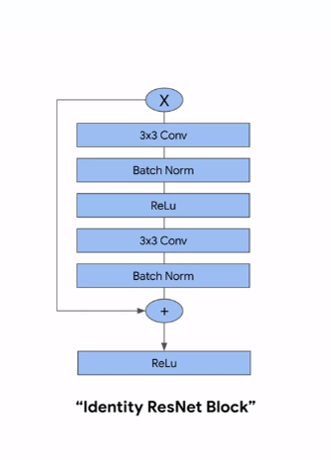

In [63]:
class ResidualIdentityBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(ResidualIdentityBlock, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.act = tf.keras.layers.Activation('relu')
    self.add = tf.keras.layers.Add()

  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.act(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.add([x, input_tensor])
    x = self.act(x)

    return x

# Test Code
resnetBlock = ResidualIdentityBlock(4, (3,3))
resnetBlock.build(input_shape=(100,512,512,4))
resnetBlock.summary()
#tf.keras.utils.plot_model(resnetBlock)

Model: "residual_identity_block_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_432 (Conv2D)          multiple                  148       
_________________________________________________________________
batch_normalization_432 (Bat multiple                  16        
_________________________________________________________________
conv2d_433 (Conv2D)          multiple                  148       
_________________________________________________________________
batch_normalization_433 (Bat multiple                  16        
_________________________________________________________________
activation_216 (Activation)  multiple                  0         
_________________________________________________________________
add_216 (Add)                multiple                  0         
Total params: 328
Trainable params: 312
Non-trainable params: 16
_________________________________________

<a name="4-3"></a>
## 4.3 Custom Losses

<a name="4-4"></a>
## 4.4 Custom Model

<a name="4-4-1"></a>
### 4.4.1 U-Net

In [ ]:
class UNet(tf.keras.Model):
  def __init__(self, ): #TODO: add missing arguments
    super(UNet, self).__init__()
    #downsaple layer
    #upsample layer
    ###

  def call(self, inputs):
    return pass
  

<a name="4-4-2"></a>
### 4.4.2 ResNet

TODO: 


1.   Add Upsampling Layer
2.   Add Downsampling Layer



Model: "res_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_identity_block_45 ( multiple                  328       
_________________________________________________________________
residual_identity_block_46 ( multiple                  328       
_________________________________________________________________
residual_identity_block_47 ( multiple                  328       
_________________________________________________________________
residual_identity_block_48 ( multiple                  328       
_________________________________________________________________
residual_identity_block_49 ( multiple                  328       
Total params: 1,640
Trainable params: 1,560
Non-trainable params: 80
_________________________________________________________________


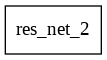

In [69]:
class ResNet(tf.keras.Model):
  def __init__(self, filters = 4, kernel_size = (3,3),  num_res_blocks = 5, weight_sharing_active = False):
    super(ResNet, self).__init__()
    
    self.num_res_blocks = num_res_blocks
    self.weight_sharing_active = weight_sharing_active
    if (weight_sharing_active):
      self.resBlock = ResidualIdentityBlock(filters, kernel_size)
    else:
      self.resBlock = [ResidualIdentityBlock(filters, kernel_size) for _ in range(num_res_blocks)]

  def call(self, input_tensor):
    x = input_tensor
    if (self.weight_sharing_active):
      for _ in range(0,self.num_res_blocks):
        x = self.resBlock(x)
    else:
      for layer in self.resBlock:
        x = layer(x)
    return x

  #def plot_Graph(self, shape):
  #  x = tf.keras.layers.Input(shape=(shape))
  #  return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
ResNet = ResNet(num_res_blocks = 5, weight_sharing_active = False)
ResNet.build(input_shape=(None,512,512,4))
ResNet.summary()
tf.keras.utils.plot_model(ResNet, show_shapes=True, expand_nested=True)

<a name="4-4-3"></a>
### 4.4.3 PatchGAN Discriminator

<a name="4-4-4"></a>
### 4.4.4 CycleGAN

<a name="4-2"></a>
## 4.2 Custom Callbacks

<a name="5"></a>
# 5. Training the Model

<a name="6"></a>
# 6. Validating the Model

<a name="A"></a>
# A. TESTING AND DEBUGGING

In [ ]:
#Prepare_filename(directory):
rgbd_samples = Combine_color_depth(DATA_PATH)
Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
Plot_Multiple_RGBD(rgbd_samples)
#Create_tensorflow_dataset(rgbd_samples)